<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>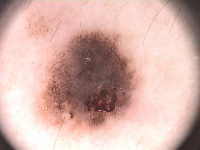</td><td>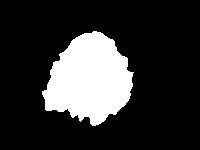</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/zda2rhvljjv3jdu/PH2Dataset.rar

In [ ]:
!ls

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

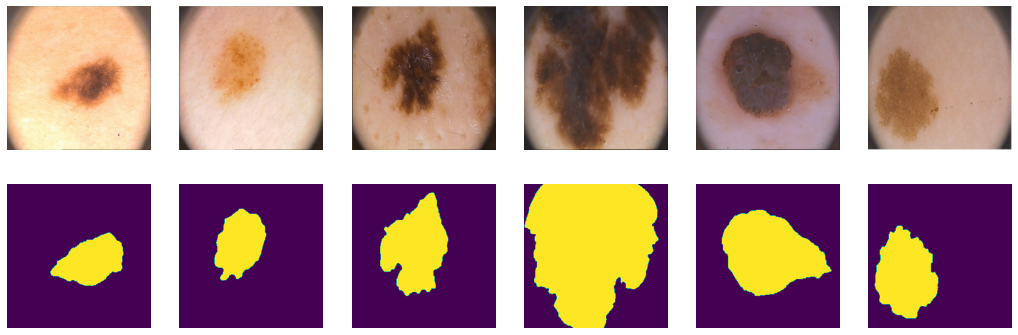

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

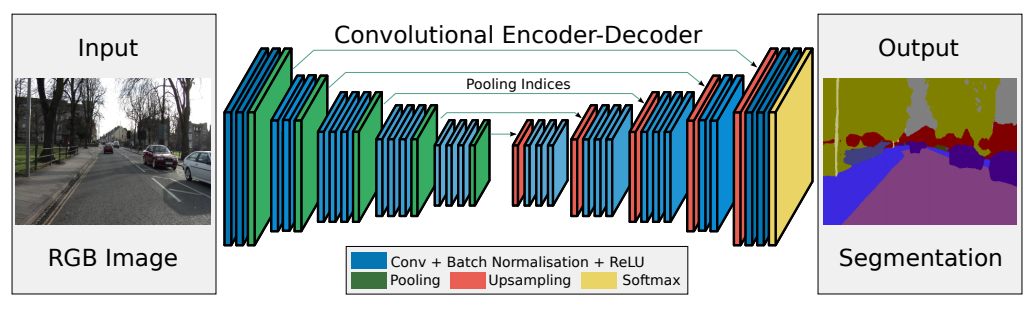

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
'''
  Комментарии далее буду писать на английском ибо так мне привычнее и удобнее
  Он не сложный, так что позволю себе такюй вольность 
'''

In [ ]:
ks = 3
pd = 1


'''
  As I found original model used kernel_size=7, but it produces lots of problems
  with training, so I decided to reduce the kernel_size 
'''


class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16
        
        '''
          bottleneck layer was removed to make the model lighter
        '''
        
        # decoder (upsampling)
        
        '''
          upsample was made with F.max_unpool2d; check the forward part
        '''
        
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=ks, padding=pd),
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        dim_0 = x.size()
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        dim_1 = e0.size()
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        dim_2 = e1.size()
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        dim_3 = e2.size()

        # decoder
        d0 = self.dec_conv0(F.max_unpool2d(e3, ind3, kernel_size=2, output_size=dim_3))
        d1 = self.dec_conv1(F.max_unpool2d(d0, ind2, kernel_size=2, output_size=dim_2))
        d2 = self.dec_conv2(F.max_unpool2d(d1, ind1, kernel_size=2, output_size=dim_1))
        d3 = self.dec_conv3(F.max_unpool2d(d2, ind0, kernel_size=2, output_size=dim_0))

        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    '''
      norm_param was added to noramlize the output
    '''
    norm_param = 1
    for i in y_real.shape:
      norm_param *= i 
    return torch.sum(y_pred - torch.mul(y_real, y_pred) + torch.log(1 + torch.exp(-torch.abs(y_pred)))) / norm_param

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    '''
      Gathering the statistics for graphs!
    '''
    loss_train = []
    loss_val = []
    scores = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            #print(Y_pred.shape)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        loss_train.append(float(avg_loss.detach()))
        # show intermediate results
        model.eval()  # testing mode
        temp = model(X_val.to(device)).to('cpu')
        loss_valid = loss_fn(Y_val, temp)
        Y_val_pred = (temp > 0.5).float()
        loss_val.append(float(loss_valid.detach()))
        Y_hat = Y_val_pred.detach().numpy() # detach and put into cpu
        '''
          It is interesting to know how many pixels were classified as the mask 
          when the picture is almost black
        '''
        print(Y_hat.sum())
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')
            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        score = score_model(model, iou_pytorch, data_ts)
        scores.append(float(score))
    return loss_train, loss_val, scores

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [torch.unsqueeze(model(X_batch.to(device)).argmax(dim=1), dim = 1).to('cpu').detach() for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.unsqueeze((model(X_batch.to(device)).max(dim=1)[0] > 0.5).float(), dim = 1).to('cpu').detach()
        scores += metric(Y_pred.to(device), Y_label.to(device)).mean().item()
    return scores/len(data)

In [ ]:
#for more convenient interaction with colab

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
#@title
model = SegNet().to(device)
model

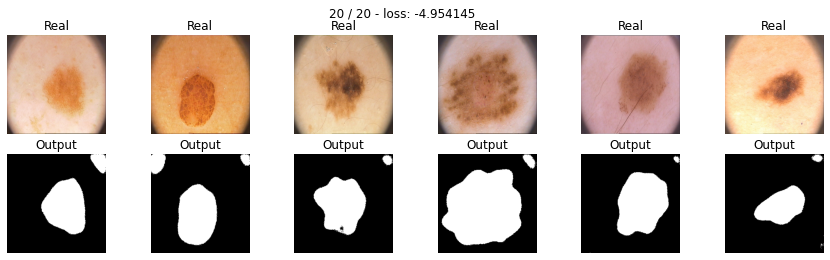

In [ ]:
#@title
max_epochs = 20
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
tr_loss, val_loss, scores = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

'''
  the graphs will be in the final part 

        |\__/,|   (`\
      _.|o o  |_   ) )
  -(((---(((--------------------------

'''

In [ ]:
#@title
score_model(model, iou_pytorch, data_val)

0.7199999690055847

Ответьте себе на вопрос: не переобучается ли моя модель?

In [ ]:
# Nope?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    num = 1 / 256 / 256
    den = sum([1 - torch.sum(2 * y_real[k, 0] * y_pred[k, 0]) \
                   / torch.sum(y_pred[k, 0] + y_real[k, 0]) for k in range (y_pred.shape[0])])
    res = den / y_pred.shape[0]
    return res 

Проводим тестирование:

The dice loss below was taken from this article:
https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b

Original dice loss performed with accuracy about 0.2 :( 

In [ ]:
def dice_loss(y_real, y_pred):
    num = 1 / 256 / 256
    den = sum([1 - torch.sum(2 * torch.mul(y_real[k, 0], y_pred[k, 0])) \
                / (torch.sum(torch.mul(y_pred[k, 0], y_pred[k, 0])) \
                + torch.sum(torch.mul(y_real[k, 0], y_real[k, 0]))) \
                for k in range (y_pred.shape[0])])
    res = den / y_pred.shape[0]
    return res

In [ ]:
model_dice = SegNet().to(device)

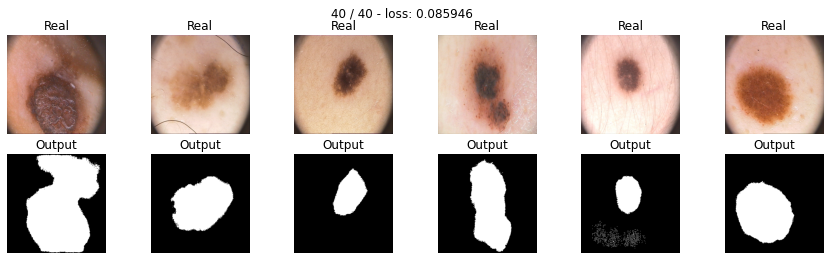

In [ ]:
max_epochs = 40
optimaizer = torch.optim.Adam(model_dice.parameters())
tr_loss, val_loss, scores = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

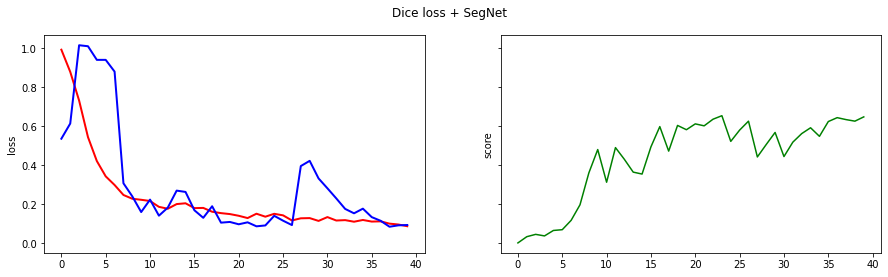

In [ ]:
import numpy as np


t = np.arange(0., max_epochs, 1)
x1 = [elem for elem in tr_loss]
x2 = [elem for elem in val_loss]
x3 = [elem for elem in scores]

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

ax1.plot(t, x1, 'r', t, x2, 'b', lw=2)
ax2.plot(t, x3, 'g')

ax1.set_ylabel('loss')
ax2.set_ylabel('score')

fig.suptitle('Dice loss + SegNet')

plt.show()

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.7139999866485596

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-6, gamma = 2):
    sigm = nn.Sigmoid()
    y_real = y_real.view(-1)
    y_pred = sigm(y_pred).view(-1).clamp(min=eps, max=1-eps)
    outp1 = torch.pow(1 - y_pred, gamma)
    outp1 = torch.mul(outp1, y_real)
    outp1 = torch.mul(outp1, torch.log(y_pred))
    outp2 = torch.pow(y_pred, gamma)
    outp2 = torch.mul(outp2, 1 - y_real)
    outp2 = torch.mul(outp2, torch.log(1 - y_pred))
    return -torch.sum(outp1 + outp2) / size[0] / size[1] / batch_size


In [ ]:
model_focal = SegNet().to(device)

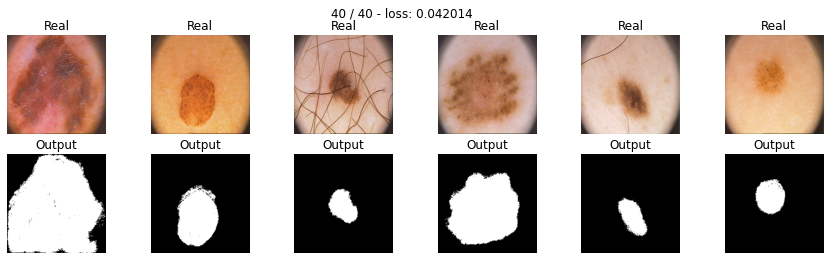

In [ ]:
max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters())
tr_loss, val_loss, scores = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

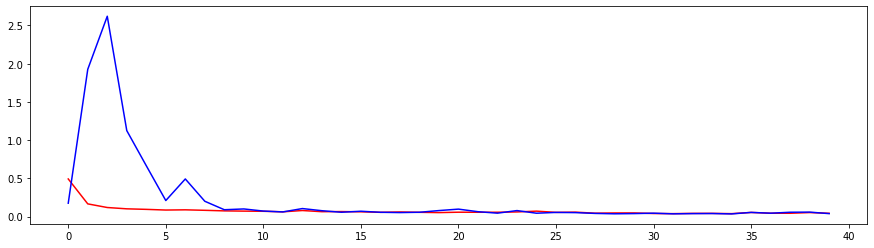

In [ ]:
import numpy as np

t = np.arange(0., max_epochs, 1)
x1 = [elem for elem in tr_loss]
x2 = [elem for elem in val_loss]
plt.plot(t, x1, 'r', t, x2, 'b')
plt.show()

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.5740000009536743

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
# Correlation Maximized Structural Similarity Loss for Semantic Segmentation
#  Structural similarity loss
def SSL(y_real, y_pred, stability_factor = 0.01, beta = 0.1, eps=1e-6):
    sigm = nn.Sigmoid()
    y_real = y_real.to('cpu')
    y_pred = sigm(y_pred).to('cpu')
    e = torch.zeros(y_real.shape)
    unfold_params = dict(kernel_size=3, dilation=1, padding=1, stride=1)
    unfold = nn.Unfold(**unfold_params)
    fold_params = dict(kernel_size=1, dilation=1, padding=0, stride=1)
    fold = nn.Fold(output_size=size, **fold_params)
    # local statistic parameters
    real_local_mean = fold(unfold(y_real).mean(dim=1)).view(-1)
    real_local_std = fold(unfold(y_real).std(dim=1)).view(-1)
    pred_local_mean = fold(unfold(y_real).mean(dim=1)).view(-1)
    pred_local_std = fold(unfold(y_real).std(dim=1)).view(-1)
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1).clamp(min=eps, max=1-eps)
    st_fc_matrix = stability_factor * torch.ones(y_real.shape)
    e = torch.divide(y_real - real_local_mean + st_fc_matrix, real_local_std + st_fc_matrix)
    e += torch.divide(y_pred - pred_local_mean + st_fc_matrix, pred_local_std + st_fc_matrix)
    e = torch.abs(e) 
    e_max = max(e)
    f = (e > beta * e_max).float()
    # cross enthropy
    pred1 = -torch.mul(y_real, torch.log(y_pred))
    pred2 = -torch.mul(1 - y_real, torch.log(1 - y_pred))
    # final
    outp = torch.mul(e, f)
    outp = torch.mul(outp, pred1 + pred2)
    M = f.sum()
    return outp.sum() / M


In [ ]:
input = torch.randn(4, 1, 256, 256)
output = torch.randn(4, 1, 256, 256)
SSL(input, output)

tensor(-0.9809)

In [ ]:
model_ssl = SegNet().to(device)

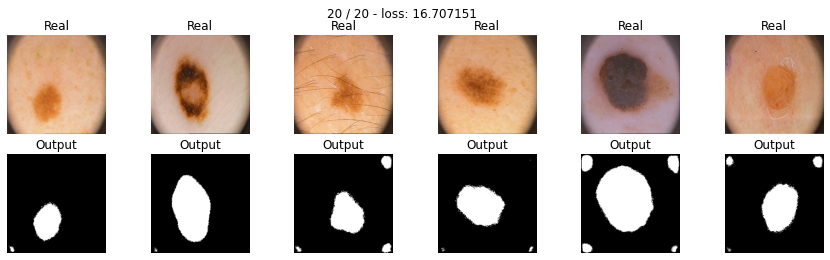

In [ ]:
max_epochs = 20
optimaizer = torch.optim.Adam(model_ssl.parameters())
tr_loss, val_loss, scores = train(model_ssl, optimaizer, SSL, max_epochs, data_tr, data_val)

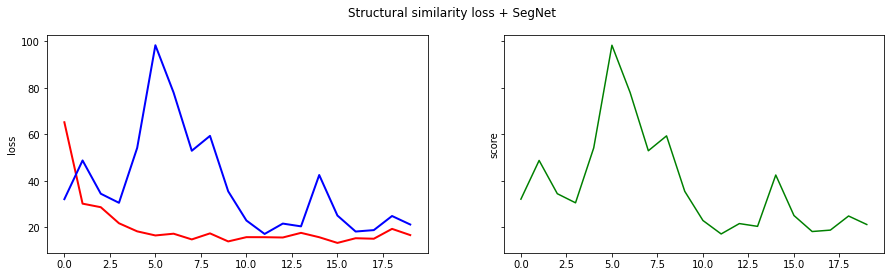

In [ ]:
import numpy as np


t = np.arange(0., max_epochs, 1)
x1 = [elem for elem in tr_loss]
x2 = [elem for elem in val_loss]
x3 = [elem for elem in val_loss]

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

ax1.plot(t, x1, 'r', t, x2, 'b', lw=2)
ax2.plot(t, x3, 'g')

ax1.set_ylabel('loss')
ax2.set_ylabel('score')

fig.suptitle('Structural similarity loss + SegNet')

plt.show()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

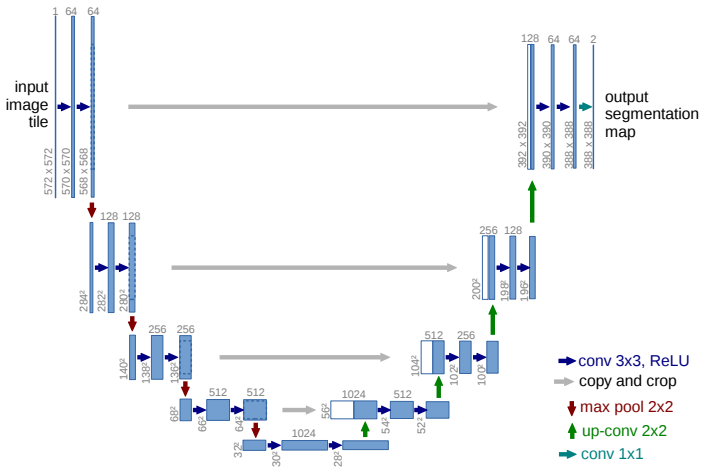

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
unet_model = UNet().to(device)

In [ ]:
ks = 3
pd = 1


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16

        # bottleneck
        '''
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        '''

        '''
          The same problem. Bottleneck is rather heavy. And rather boring. 
        '''

        # decoder (upsampling)
        #self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        
        #self.upsample1 = nn.MaxUnpool2d(kernel_size=2) # 32 -> 64
        
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        
        #self.upsample2 = nn.MaxUnpool2d(kernel_size=2)  # 64 -> 128
        
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        
        #self.upsample3 = nn.MaxUnpool2d(kernel_size=2)  # 128 -> 256
        
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=ks, padding=pd),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0, ind0 = self.pool0(e0)
        dim_0 = x.size()
        e1 = self.enc_conv1(p0)
        p1, ind1 = self.pool1(e1)
        dim_1 = p0.size()
        e2 = self.enc_conv2(p1)
        p2, ind2 = self.pool2(e2)
        dim_2 = p1.size()
        e3 = self.enc_conv3(p2)
        p3, ind3 = self.pool3(e3)
        dim_3 = p2.size()

        # bottleneck
        b = p3 #self.bottleneck_conv(p3)

        # decoder
        d0 = self.dec_conv0(torch.cat((F.max_unpool2d(b, ind3, kernel_size=2, output_size=dim_3), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((F.max_unpool2d(d0, ind2, kernel_size=2, output_size=dim_2), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((F.max_unpool2d(d1, ind1, kernel_size=2, output_size=dim_1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((F.max_unpool2d(d2, ind0, kernel_size=2, output_size=dim_0), e0), dim=1))
        return d3

In [ ]:
unet_model = UNet().to(device)

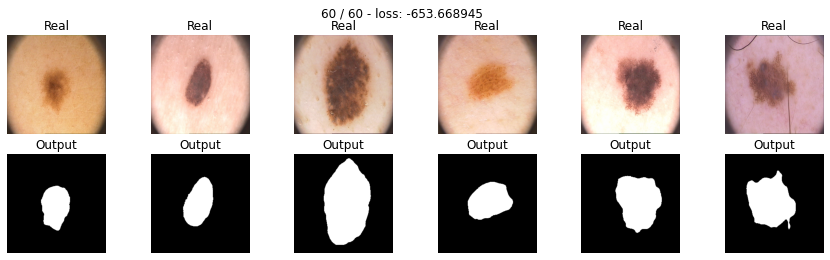

In [ ]:
tr_loss, val_loss, scores = train(unet_model, torch.optim.Adam(unet_model.parameters()), bce_loss, 60, data_tr, data_val)

In [ ]:
max_epochs = 60

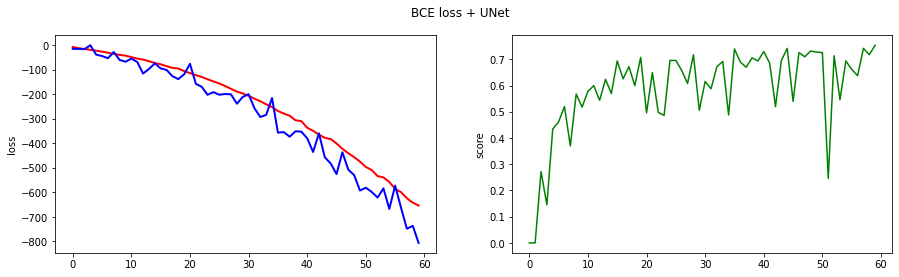

In [ ]:
import numpy as np


t = np.arange(0., max_epochs, 1)
x1 = [elem for elem in tr_loss]
x2 = [elem for elem in val_loss]
x3 = [elem for elem in scores]

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(t, x1, 'r', t, x2, 'b', lw=2)
ax2.plot(t, x3, 'g')

ax1.set_ylabel('loss')
ax2.set_ylabel('score')

fig.suptitle('BCE loss + UNet')

plt.show()

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.728000009059906

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
ks = 3
pd = 1


class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        self.pool0 = nn.Sequential( 
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=ks, padding=pd, stride=2)
        )
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=ks, padding=pd, stride=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=ks, padding=pd, stride=2) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=ks, padding=pd, stride=2) # 32 -> 16

        # bottleneck
        '''
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        '''
        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=ks + 1, padding=pd, stride=2) # 16 -> 32
        
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=ks + 1, padding=pd, stride=2) # 32 -> 64
        
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=ks + 1, padding=pd, stride=2)# 64 -> 128
        
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        
        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=ks + 1, padding=pd, stride=2)
        )  # 128 -> 256
        
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=ks, padding=pd),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=ks, padding=pd),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        # bottleneck
        b = p3 #self.bottleneck_conv(p3)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1))
        return d3

In [ ]:
unet2_model = UNet2().to(device)

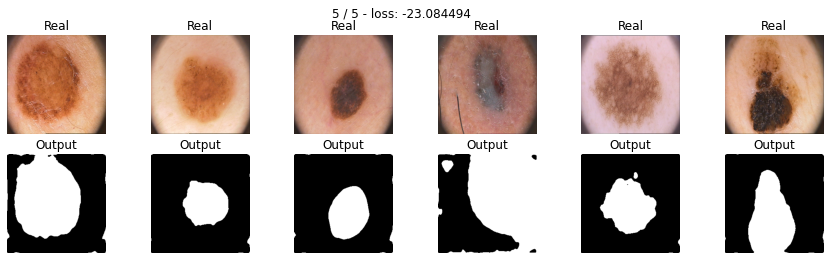

([-7.371400356292725,
  -11.424237251281738,
  -14.982359886169434,
  -19.446847915649414,
  -23.08449363708496],
 [47.09856414794922,
  -13.08637523651123,
  6.165144920349121,
  -14.100448608398438,
  -27.110668182373047],
 [0.07400000207126141,
  0.11000000312924385,
  0.13000000193715094,
  0.2240000009536743,
  0.38800000846385957])

In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 5, data_tr, data_val)

'''
    It works! There is only 5 epochs cause the most interesting part is below
'''

# Сравнение!

In [ ]:
def train_finale(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    loss_train = []
    loss_val = []
    scores = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            #print(Y_pred.shape)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        loss_train.append(float(avg_loss.detach()))
        # show intermediate results
        model.eval()  # testing mode
        temp = model(X_val.to(device)).to('cpu')
        loss_valid = loss_fn(Y_val, temp)
        Y_val_pred = (temp > 0.5).float()
        loss_val.append(float(loss_valid.detach()))
        Y_hat = Y_val_pred.detach().numpy() # detach and put into cpu
        score = score_model(model, iou_pytorch, data_ts)
        scores.append(float(score))
    return loss_train, loss_val, scores

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


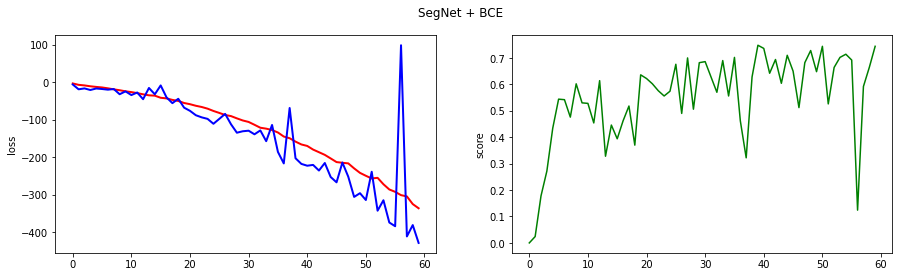

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


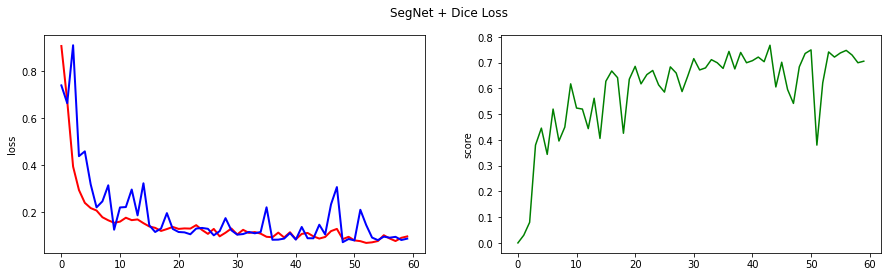

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


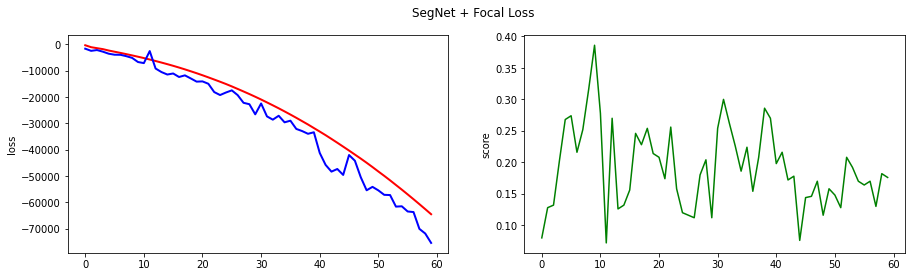

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


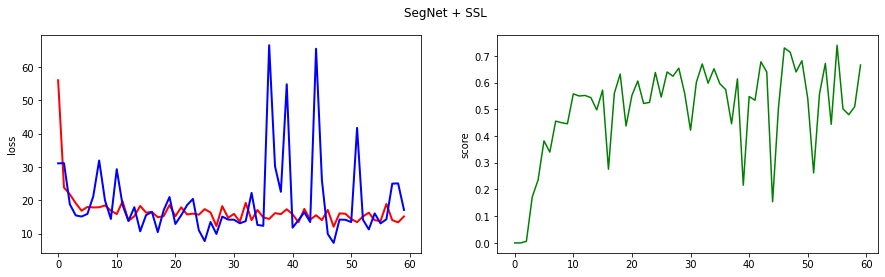

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


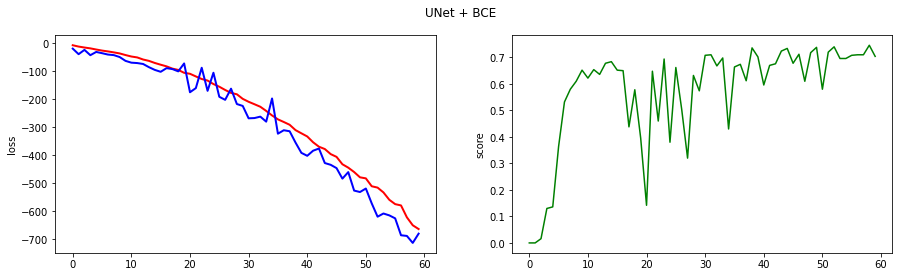

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


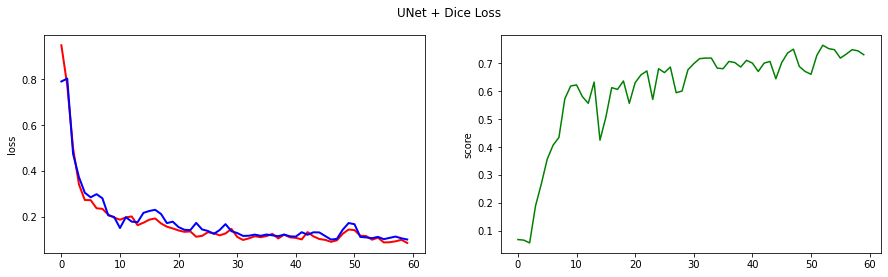

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


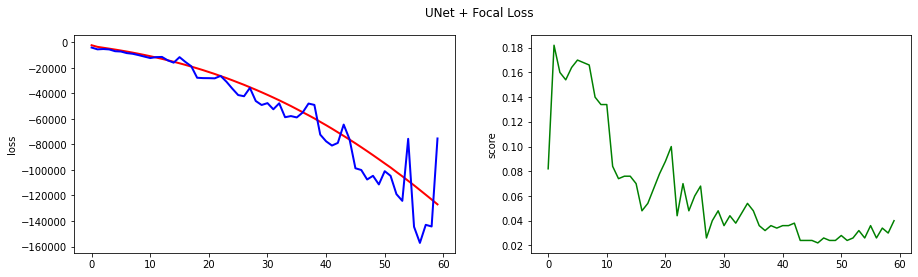

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


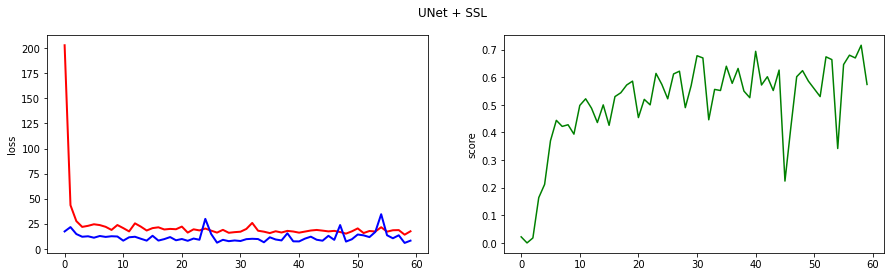

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


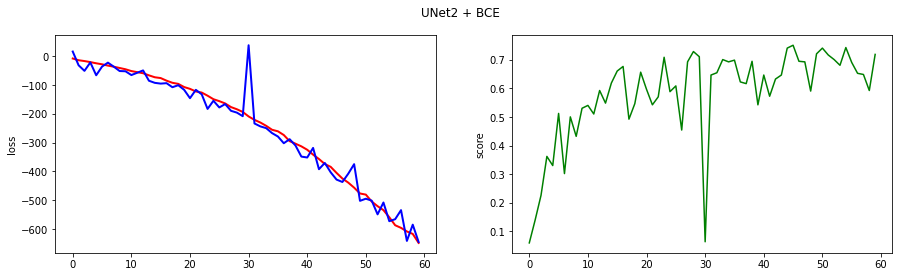

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


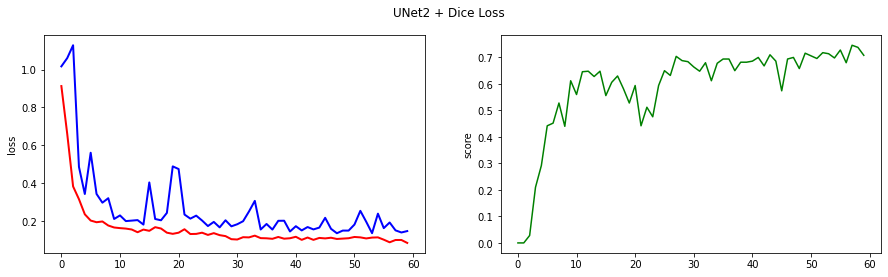

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


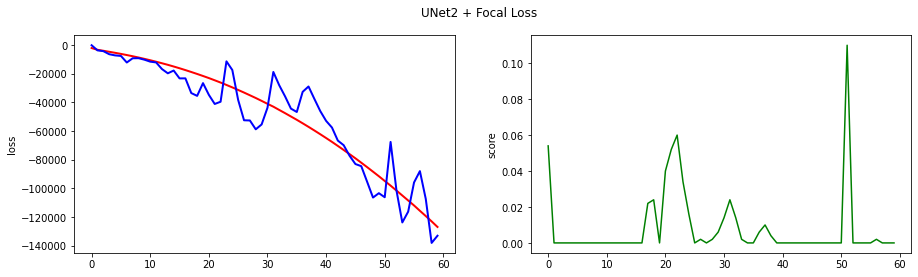

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


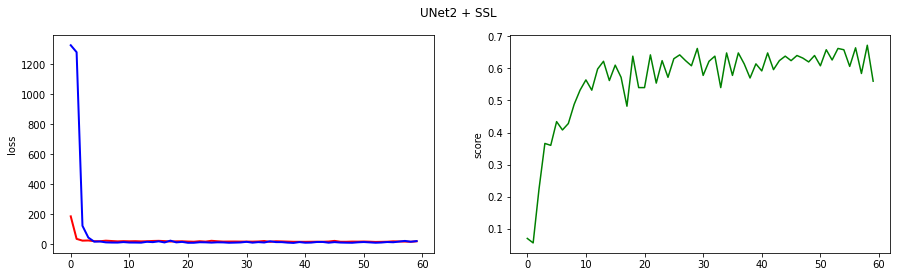

In [ ]:
max_epochs = 60

models = [SegNet, UNet, UNet2]
mod_names = ["SegNet", "UNet", "UNet2"]
losses = [bce_loss, dice_loss, focal_loss, SSL]
l_names = ["BCE", "Dice Loss", "Focal Loss", "SSL"]
'''
  С фокальным лоссом произошло недоразумение. Был взят нерабочий для этой части,
  поэтому графики с фокальным лоссом не верны. Для них был сделана отдельная 
  подобная ячейка.
'''
for mod, mod_name in zip(models, mod_names):
    for loss, l_name in zip(losses, l_names):
        model = mod().to(device)
        optimizer = torch.optim.Adam(model.parameters())
        tr_loss, val_loss, scores = train_finale(model, optimizer, loss, max_epochs, data_tr, data_val)

        t = np.arange(0., max_epochs, 1)
        x1 = [elem for elem in tr_loss]
        x2 = [elem for elem in val_loss]
        x3 = [elem for elem in scores]

        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(t, x1, 'r', t, x2, 'b', lw=2)
        ax2.plot(t, x3, 'g')

        ax1.set_ylabel('loss')
        ax2.set_ylabel('score')

        fig.suptitle(f'{mod_name} + {l_name}')

        plt.show()

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


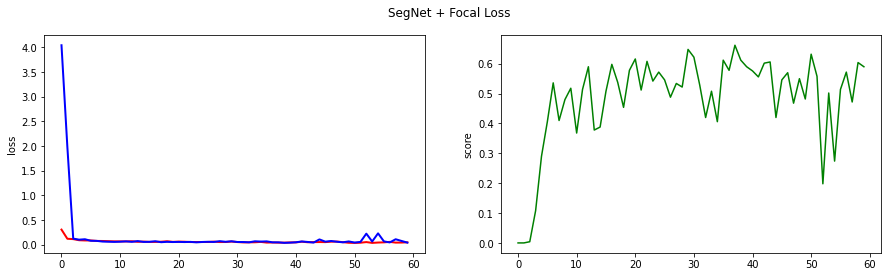

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


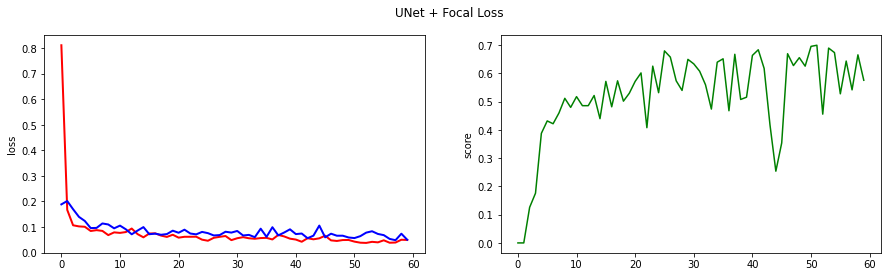

* Epoch 1/60
* Epoch 2/60
* Epoch 3/60
* Epoch 4/60
* Epoch 5/60
* Epoch 6/60
* Epoch 7/60
* Epoch 8/60
* Epoch 9/60
* Epoch 10/60
* Epoch 11/60
* Epoch 12/60
* Epoch 13/60
* Epoch 14/60
* Epoch 15/60
* Epoch 16/60
* Epoch 17/60
* Epoch 18/60
* Epoch 19/60
* Epoch 20/60
* Epoch 21/60
* Epoch 22/60
* Epoch 23/60
* Epoch 24/60
* Epoch 25/60
* Epoch 26/60
* Epoch 27/60
* Epoch 28/60
* Epoch 29/60
* Epoch 30/60
* Epoch 31/60
* Epoch 32/60
* Epoch 33/60
* Epoch 34/60
* Epoch 35/60
* Epoch 36/60
* Epoch 37/60
* Epoch 38/60
* Epoch 39/60
* Epoch 40/60
* Epoch 41/60
* Epoch 42/60
* Epoch 43/60
* Epoch 44/60
* Epoch 45/60
* Epoch 46/60
* Epoch 47/60
* Epoch 48/60
* Epoch 49/60
* Epoch 50/60
* Epoch 51/60
* Epoch 52/60
* Epoch 53/60
* Epoch 54/60
* Epoch 55/60
* Epoch 56/60
* Epoch 57/60
* Epoch 58/60
* Epoch 59/60
* Epoch 60/60


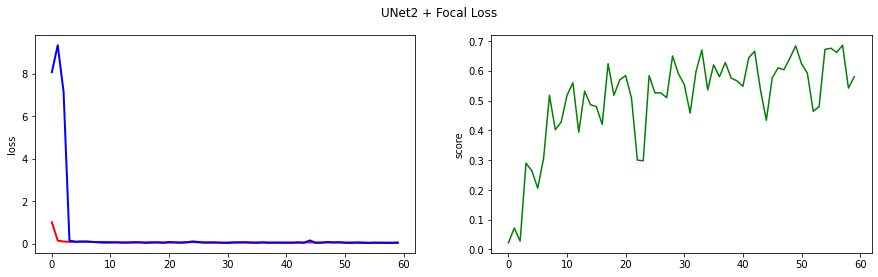

In [ ]:
max_epochs = 60

models = [SegNet, UNet, UNet2]
mod_names = ["SegNet", "UNet", "UNet2"]
losses = [focal_loss]
l_names = ["Focal Loss"]
for mod, mod_name in zip(models, mod_names):
    for loss, l_name in zip(losses, l_names):
        model = mod().to(device)
        optimizer = torch.optim.Adam(model.parameters())
        tr_loss, val_loss, scores = train_finale(model, optimizer, loss, max_epochs, data_tr, data_val)

        t = np.arange(0., max_epochs, 1)
        x1 = [elem for elem in tr_loss]
        x2 = [elem for elem in val_loss]
        x3 = [elem for elem in scores]

        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(t, x1, 'r', t, x2, 'b', lw=2)
        ax2.plot(t, x3, 'g')

        ax1.set_ylabel('loss')
        ax2.set_ylabel('score')

        fig.suptitle(f'{mod_name} + {l_name}')

        plt.show()

Сделайте вывод, какая из моделей лучше

In [ ]:
'''
  Мне больше всего понравились графики UNet и Dice Loss
  Ниже я об этом подробнее напишу 
'''

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

Думаю, здесь попробуем порассуждать на тему лучшей модели для того чтобы сегментировать родинки. Лучший score у всех моделей примерно одинаковый, так что интереснее будет посмотреть на другие параметры. Для лучшей читаемости графиков рекомендую включить светлую тему.

## SegNet

### BCE loss

Взглянем на графики лосса и метрики. 
Максимальный скор получился около 0.7, что вполне неплохо. Мне не очень нравится выпуклость графика. По экспериментам, после 80 эпохи график стабилизируется.

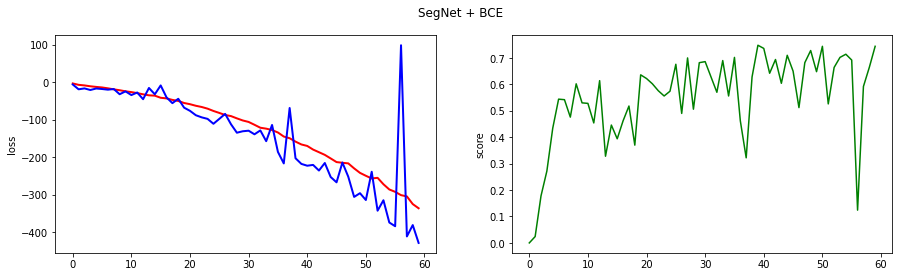

### Dice loss

Здесь представлен график лосса и метрики. С помощью формулы в ноутбуке не получилось добиться удобоворимого результата, поэтому я нашёл статью и реализовал версию лосса оттуда. Устойчивость неплохая, а метрика очень даже неплохая по сравнению с остальными моделями. Явного переобучения не видно, но по результатам других экспериментов после 100 эпох оно начинает переобучаться.

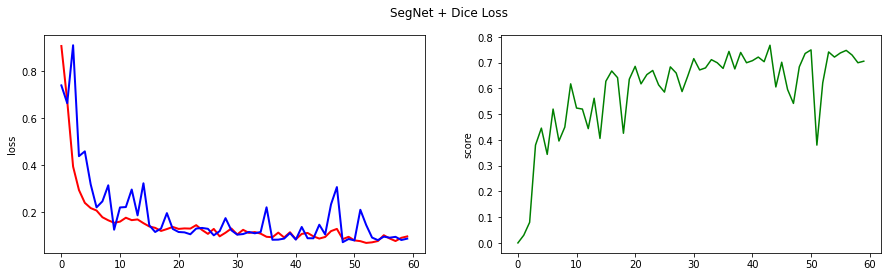

### Focal loss

В этом случае сходимость наблюдается почти сразу же. Однако по метрике модель показывает себя хуже. Опять же явного переобучения не наблюдается. При большем числе эпох ситуация почти не меняется.

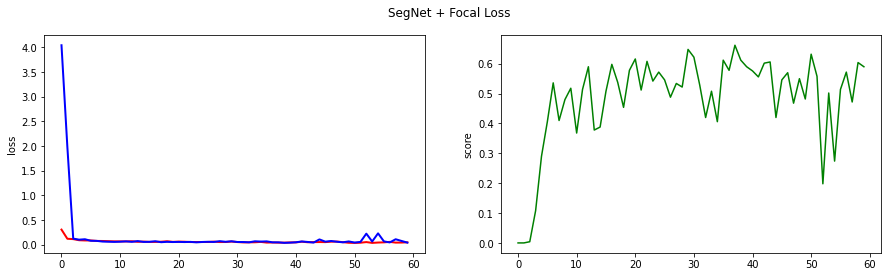

### SSL

Я выбрал для реализации лосс из этой статьи: 
Correlation Maximized Structural Similarity Loss for Semantic Segmentation.

Мне показалась интересной эта идея. К тому же его довольно интересно программировать. (В отличие от лосса из Topology-Preserving Deep Image Segmentation)

На train наблюдается довольно быстрая сходимость, однако на valid модель ведёт себя не стабильно. Результат хороший, но процесс обучения надо контролировать, что видно по графику метрики.

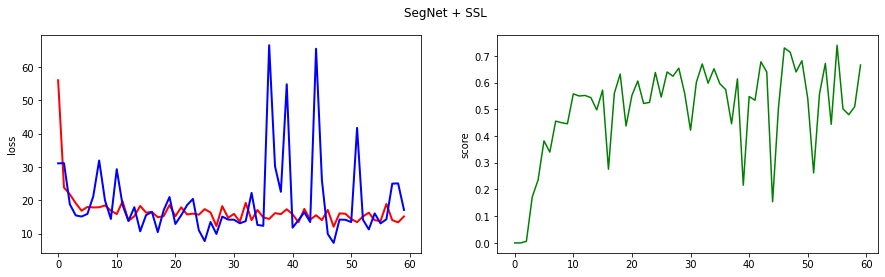

### Выводы?

Мне кажется, что лучшим выбором по результатам моих экспериментов будет Dice Loss. Модель довольно быстро сходится к весьма неплохому результату и ведёт себя весьма стабильно

## UNet

### BCE loss

Тут картина схожа с тем, что было у SegNet сети. Однако на valid график более спокойный, что мне кажется вполне хорошим знаком.

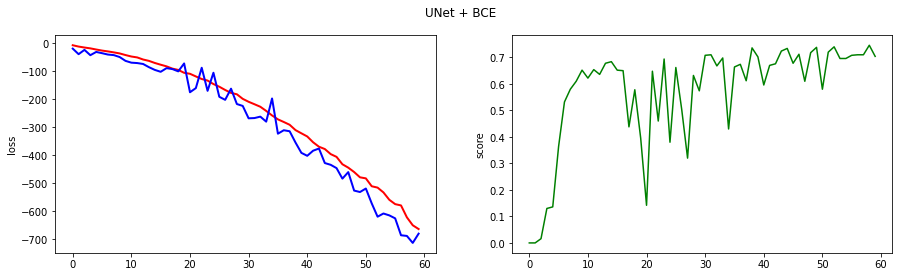

### Dice loss

Опять картина показывает улучшение результатов в плане устойчивости по сравнению с SegNet.
Хорошая сходимость, нормальная метрика. Красота!

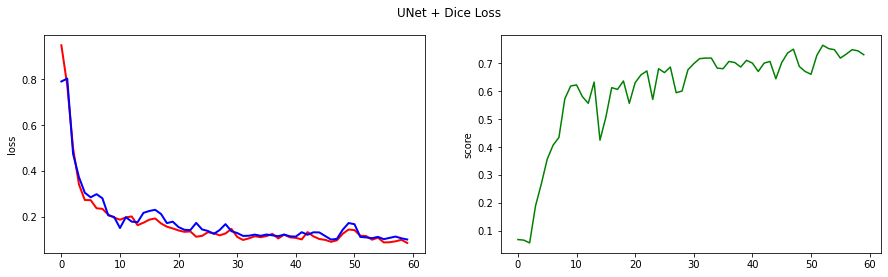

### Focal loss

Модель значительно превосходит SegNet по метрике, если сравнивать при той же loss функции. Но колебания метрики всё ещё значительные.

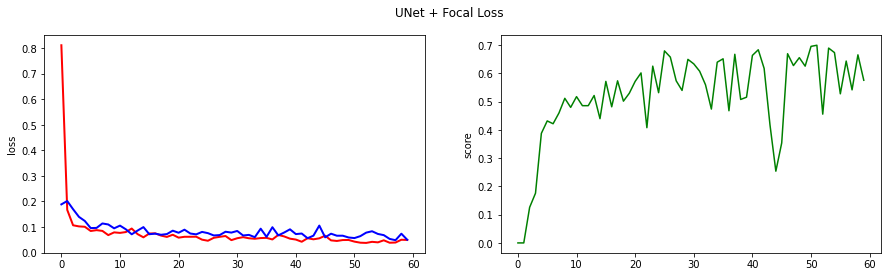

### SSL

Картина похожа на предыдущую. Колебания метрики ниже, чем у SegNet. Но максимальное значение похожее.


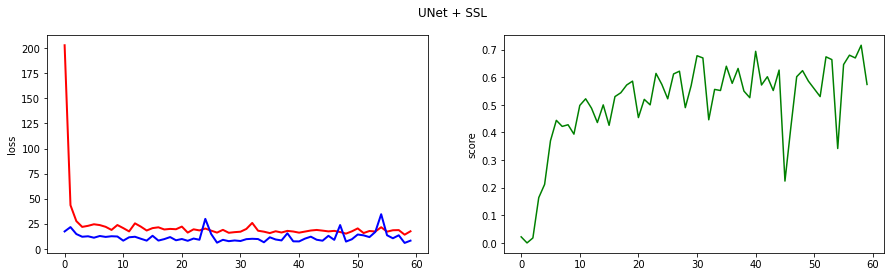

### Выводы!

Опять лучший результат модель показывает при использовании Dice loss. В плане устойчивости модель ведёт себя лучше, чем SegNet при любой функции потерь. Однако, изходя из архитектурных различий, этого следовало ожидать. По метрике в среднем тоже лучше.

## Unet2

### BCE loss

Устойчивость функции потерь на valid ещё лучше, если не считать пары выбросов.

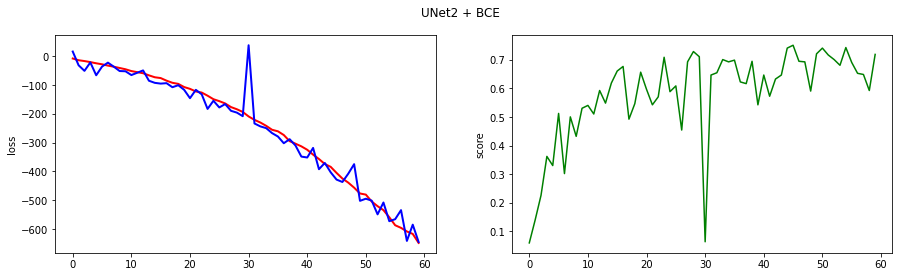

### Dice loss

При этой функции потерь модель обучается чуть менее устойчиво. А в остальном всё очень похоже.

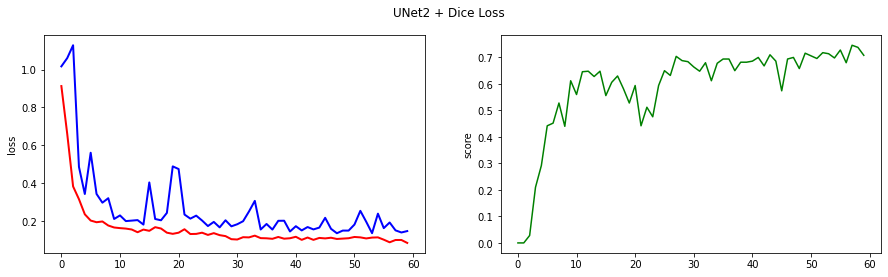

### Focal loss

Картина скорее схожа с тем, что наблюдалось у SegNet, однако по метрике модель всё ещё гораздо лучше.

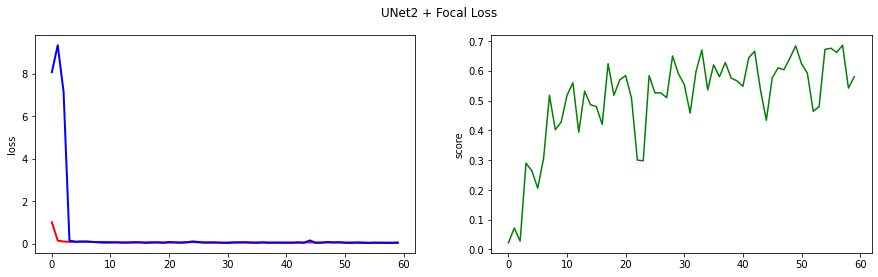

### SSL

Тут результат был хуже, чем в остальных случаях. Метрика то устойчиво себя ведёт, но в среднем она хуже.

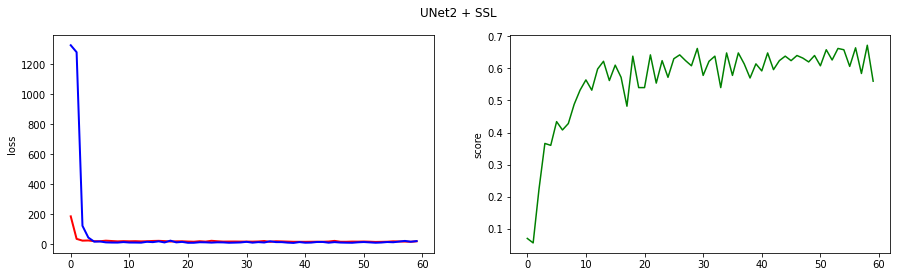

###Выводы.

Лучший результат всё ещё достигается с помощью Dice loss. Модель показывает чуть худший результат, по сравнению с предыдущей. Однако в среднем всё ещё превосходит SegNet.

##Итог!

Суммируя всё вышесказанное, можно сделать следующие выводы*:

1. Лучшая по максимальной метрике: SegNet + Dice Loss

2. Лучшая по средней метрике: UNet + Dice Loss

*А ещё из интересного:*

3. Лучшая по устойчивости валидационного лосса относительно тренировачного:  UNet2 + BCE Loss

4. Просто самая быстрая по обучению: SegNet + Dice Loss

*Накипело:*

5. Приз зрительских симпатий: UNet + Dice loss
(какой график визуально больше понравился соседям физикам)

6. По количеству нервных клеток потраченных на реализацию: UNet2 + Focal loss



---



**Естественно, это всё раздолье получается по результатам моих экспериментов*